# Neural Network on Different Distribution Data

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.datasets import make_blobs, make_circles, make_classification, make_moons, make_gaussian_quantiles
from matplotlib import pyplot as plt

# Set the random seed

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1)

# Build the Sequential and Module 

In [3]:
class Module:
    def __init__(self):
        self.layers = {}
        
    def __call__(self, a):
        for layer_index in self.layers:
            a = self.layers[layer_index].forward(a)
        return a
            
    def backward(self, dLdz):
        for layer_index in reversed(self.layers):
            dLdz = self.layers[layer_index].backward(dLdz)
        
    def update(self, learning_rate=0.01):
        for layer_index in reversed(self.layers):
            try:
                self.layers[layer_index].w -= learning_rate * self.layers[layer_index].dLdw
                self.layers[layer_index].b -= learning_rate * self.layers[layer_index].dLdb
            except AttributeError:
                None
            
    def model_class(self, classes):
        self.classes = classes
        
    def pred(self, a):
        for layer_index in self.layers:
            a = self.layers[layer_index].forward(a)
        return self.classes[torch.argmax(a)]
    
    def add_module(self, layer_index, module):
        if layer_index in self.layers:
            raise ValueError(f"Module with layer index '{layer_index}' already exists.")
        self.layers[layer_index] = module
        
    def __repr__(self):
        repr_string = f"Module(\n"
        for layer_index in self.layers:
            repr_string += f"  ({layer_index}): {self.layers[layer_index]}\n"
        repr_string += ")"
        return repr_string
    
class Sequential(Module):
    def __init__(self, *X):
        super(Sequential, self).__init__()
        for index, layer in enumerate(X):
            if not isinstance(layer, Module):
                raise ValueError(f"Argument at index {index} is not an instance of Module")

            self.add_module(index, layer)

# Build Neural Network layer

In [4]:
class NN(Module):
    def __init__(self, in_size, out_size):
        device = (
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
            )
        self.device = device
        self.w = torch.randn((out_size, in_size), device=self.device)
        self.b = torch.randn((len(self.w), 1), device=self.device)
    
    def forward(self, a):
        self.a = a.to(self.device)
        self.z = torch.matmul(self.w, self.a) + self.b
        return self.z
    
    def backward(self, dLdz):
        self.dLdz = dLdz.to(self.device)
        self.dLdw = torch.kron(self.dLdz, self.a.T)
        self.dLdb = self.dLdz
        self.dLda = torch.matmul(self.w.T, self.dLdz)
        return self.dLda
    
    def __repr__(self):
        return "NN"

# Build Activation function

In [5]:
class ReLu(Module):
    def forward(self, a):
        self.a = a
        self.z = torch.where(a>0, a, 0.)
        return self.z
    
    def backward(self, dLdz):
        self.dLdz = dLdz
        self.dLda = torch.multiply(torch.where(self.z>0, 1., 0.), dLdz)
        return self.dLda
    
    def __repr__(self):
        return "ReLu"
    
class Sigmoid(Module):
    def forward(self, a):
        self.a = a
        self.z = 1/(1 + torch.exp(-a))
        return self.z
    
    def backward(self, dLdz):
        self.dLdz = dLdz
        self.dLda = torch.multiply(torch.exp(-self.z)/torch.pow(1 + torch.exp(-self.z), 2), dLdz)
        return self.dLda
    
    def __repr__(self):
        return "Sigmoid"
    
class Tanh(Module):
    def forward(self, a):
        self.a = a
        self.z = torch.tanh(a)
        return self.z
    
    def backward(self, dLdz):
        self.dLdz = dLdz
        self.dLda = torch.multiply(1 - torch.pow(torch.tanh(self.z), 2), dLdz)
        return self.dLda
    
    def __repr__(self):
        return "Tanh"

# Build Loss function

In [6]:
class MSE_loss(Module):
    def __init__(self):
        None
    
    def __call__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred
        return 0.5 * torch.pow(y - y_pred, 2)
    
    def backward(self):
        return self.y_pred - self.y
    
    def __repr__(self):
        return "MSE_loss"

# Create Datasets from Scikit-Learn

In [7]:
samples = 200

datasets = [
    make_blobs(n_samples=samples, centers=2, n_features=2, random_state=1),
    make_blobs(n_samples=samples, centers=2, n_features=2, random_state=6),
    make_moons(n_samples=samples, noise=0.15, random_state=0),
    make_circles(n_samples=samples, noise=0.15, factor=0.3, random_state=0),
    make_gaussian_quantiles(n_samples=samples, n_features=2, n_classes=2, random_state=0),
    make_classification(n_samples=samples, n_features=2, random_state=1, n_redundant=0, n_informative=1, n_clusters_per_class=1),
    make_classification(n_samples=samples, n_features=2, random_state=1, n_redundant=0, n_informative=2, n_clusters_per_class=1),
    make_classification(n_samples=samples, n_features=2, random_state=1, n_redundant=0, n_informative=2),
    make_blobs(n_samples=samples, centers=3, n_features=2, random_state=1),
    make_blobs(n_samples=samples, centers=4, n_features=2, random_state=6),
    make_gaussian_quantiles(n_samples=samples, n_features=2, n_classes=3, random_state=0),
    make_gaussian_quantiles(n_samples=samples, n_features=2, n_classes=4, random_state=0),
]

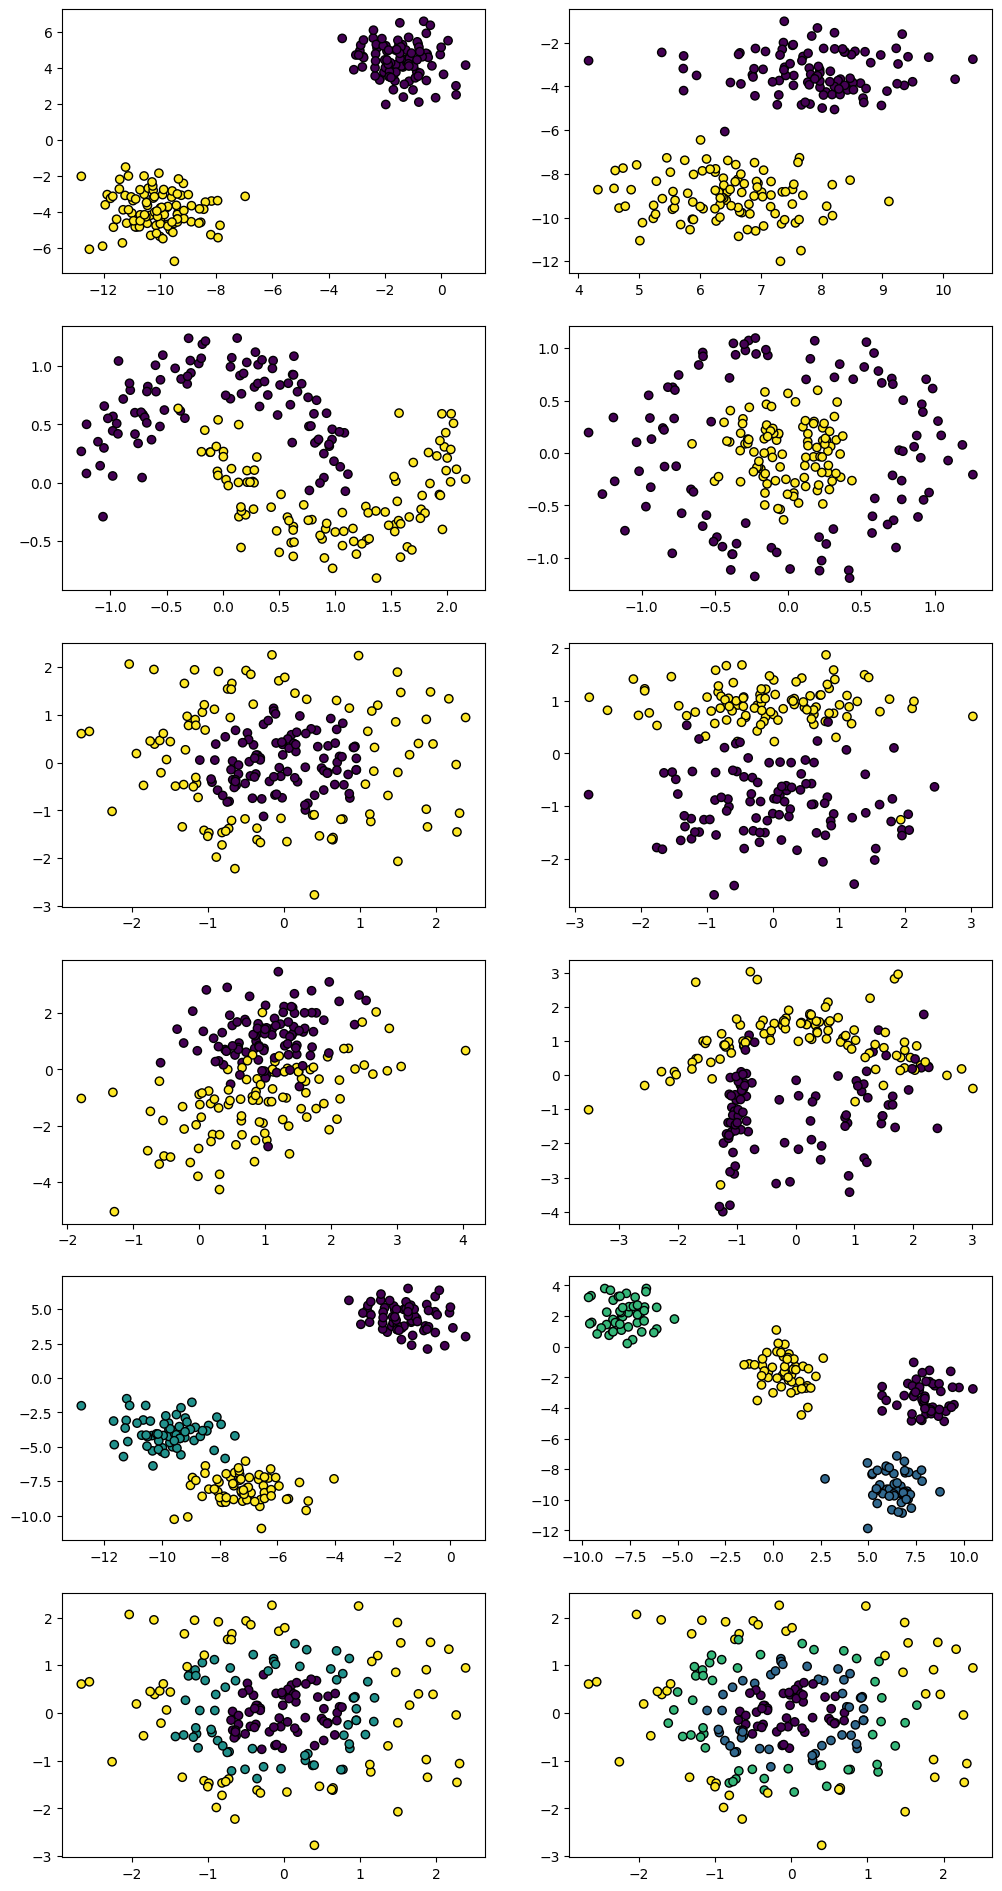

In [8]:
col = 2
row = int(len(datasets)/col)
plt.subplots(row, col, figsize=(12, 24))
for i in range(col):
    for j in range(row):
        X = datasets[row*i+j][0]
        y = datasets[row*i+j][1]
        plt.subplot(row, col, row*i+j+1)
        plt.scatter(X[:,0], X[:,1], c=y, edgecolor="k")

# Set the dataset transform 

In [9]:
class StandardScaler:
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

def y_transform(y, classes, device="cpu"):
    Y = torch.zeros((len(y), classes), device=device)
    for i in range(len(y)):
        Y[i][int(y[i])] = 1.
    return Y

# Build Model

In [10]:
Model = Sequential(
    NN(2, 5),
    Tanh(),
    NN(5, 10),
    ReLu(),
    NN(10, 20),
    ReLu(),
    NN(20, 10),
    ReLu(),
    NN(10, 4),
    Sigmoid()
)

Model.classes = torch.tensor([0, 1, 2, 3])

loss_fn = MSE_loss()
device = (
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
            )

# Set the training process

In [11]:
def train(X, Y, model, loss_fn, learning_rate):
    train_loss = 0
    for i in range(len(X)):
        x, y = torch.atleast_2d(X[i].to(device)).T, torch.atleast_2d(Y[i].to(device)).T

        # Forward
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        train_loss += loss

        # Backpropagation
        dLdz = loss_fn.backward()
        model.backward(dLdz)
        model.update(learning_rate=learning_rate)

    train_loss /= len(X)
    return train_loss

# Training and Plot the results

Dataset[1/12]


Epoch: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s, Training_loss=3.34993e-09]  


Dataset[2/12]


Epoch: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s, Training_loss=2.5254027e-10]


Dataset[3/12]


Epoch: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, Training_loss=8.845514e-09]  


Dataset[4/12]


Epoch: 100%|██████████| 300/300 [00:53<00:00,  5.64it/s, Training_loss=7.383106e-08]  


Dataset[5/12]


Epoch: 100%|██████████| 300/300 [00:53<00:00,  5.62it/s, Training_loss=2.366759e-08]  


Dataset[6/12]


Epoch: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s, Training_loss=1.555218e-05]


Dataset[7/12]


Epoch: 100%|██████████| 500/500 [01:28<00:00,  5.64it/s, Training_loss=2.3805539e-08] 


Dataset[8/12]


Epoch: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s, Training_loss=4.4864277e-07]


Dataset[9/12]


Epoch: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s, Training_loss=1.7953195e-07]


Dataset[10/12]


Epoch: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s, Training_loss=0.010236971]


Dataset[11/12]


Epoch: 100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s, Training_loss=2.3824205e-06]


Dataset[12/12]


Epoch: 100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s, Training_loss=0.060267333]


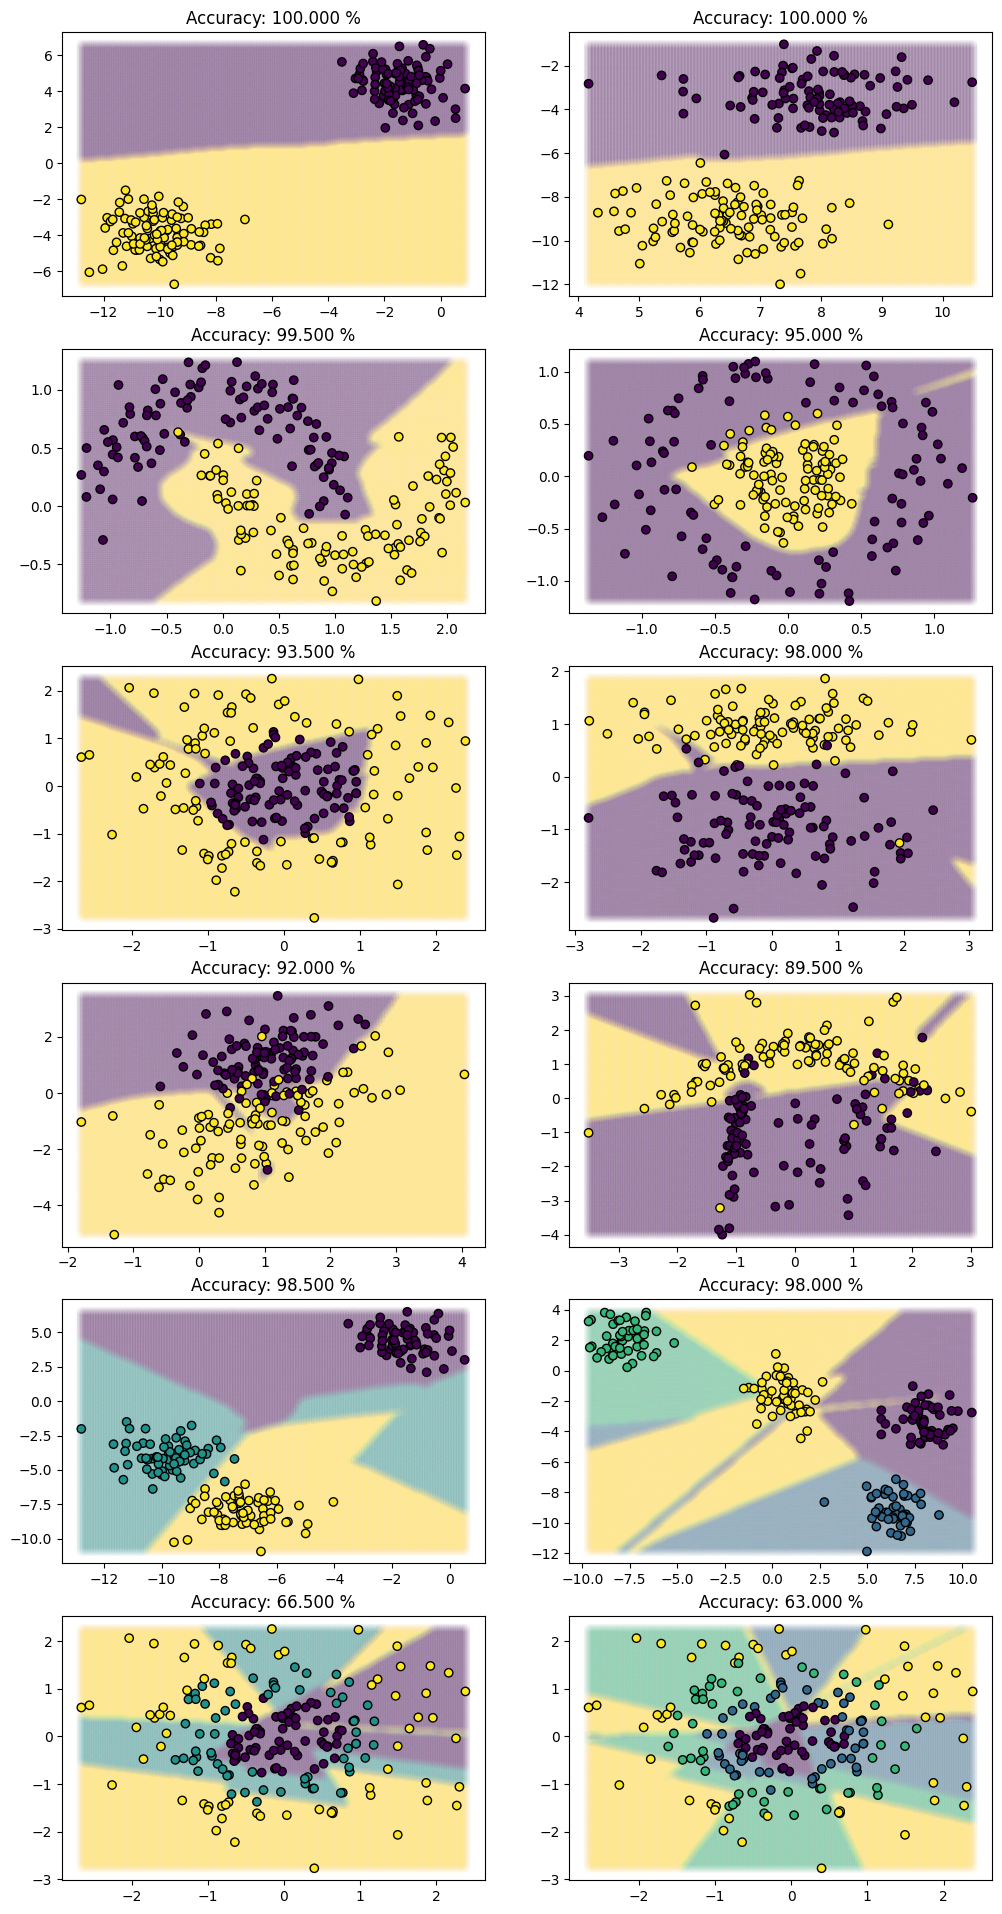

In [12]:
transform = StandardScaler()
epoch = np.array([100, 100, 500, 300, 300, 100, 500, 100, 100, 100, 1000, 1000])
learning_rate = np.array([0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.01, 0.01, 0.005, 0.005])

col = 2
row = int(len(datasets)/col)
plt.subplots(row, col, figsize=(12, 24))

for i in range(col):
    for j in range(row):
        print(f"Dataset[{row*i+j+1}/{col*row}]")
        train_loss = 0
        
        # Load Dataset
        X = datasets[row*i+j][0]
        y = datasets[row*i+j][1]
        X_train = torch.tensor(X, device="cuda").to(torch.float32)
        X_train = transform.fit_transform(X_train)
        y_train = y_transform(y, 4, "cuda")
        
        # Training
        loop = tqdm(range(epoch[row*i+j]))
        for t in  enumerate(loop):
            train_loss = train(X_train, y_train, Model, loss_fn, learning_rate[row*i+j])
            loop.set_description("Epoch")
            loop.set_postfix(Training_loss = str(train_loss.cpu().numpy()[-1,-1]))
            
        # Calculate the accuracy
        pred = np.array([])
        for k in range(len(X_train)):
            x_train = torch.atleast_2d(X_train[k].to(device)).T
            pred = np.append(pred, Model.pred(x_train).cpu().numpy())
        accuracy = np.sum(y==pred)/len(y)
        
        # Plot the results
        interval = np.linalg.norm(np.array([np.max(X[:,0])-np.min(X[:,0]), np.max(X[:,1])-np.min(X[:,1])]))/(len(X)*1.2)
        x1 = np.arange(np.min(X[:,0]), np.max(X[:,0])+interval, interval)
        x2 = np.arange(np.min(X[:,1]), np.max(X[:,1])+interval, interval)
        x1, x2 = np.meshgrid(x1, x2)
        mesh_X = np.array([x1.flatten(), x2.flatten()]).T
        mesh_X_transform = transform.transform(torch.tensor(mesh_X, device="cuda"))
        pred = np.array([])
        for l in range(len(mesh_X_transform)):
            x = torch.atleast_2d(mesh_X_transform[l].to(device).to(torch.float32)).T
            pred = np.append(pred, Model.pred(x).cpu().numpy())

        plt.subplot(row, col, row*i+j+1)
        plt.scatter(mesh_X[:,0], mesh_X[:,1], c=pred, alpha=0.02)
        plt.scatter(X[:,0], X[:,1], c=y, edgecolor="k")
        plt.title(f"Accuracy: {accuracy*100:.3f} %")
plt.show()
        